In [3]:
from IPython.display import HTML

HTML('''<script>
hide_code=true; 
function code_toggle() {
   if (hide_code){
       $('div.input').hide();
   } else {
       $('div.input').show();
   }
   hide_code = !hide_code
} 
$( document ).ready(code_toggle);
</script>
NOTE: the code in this notebook is hidden for better readability.  
To toggle on/off, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
%matplotlib inline
import os
import numpy as np
import csv
import math
import ogr
import pickle
from osgeo import gdal, osr, gdalconst
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
import itertools
from itertools import cycle
from scipy import interp
import matplotlib.pyplot as plt
from IPython.display import Image

/home/astridv/anaconda2/envs/gl-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# <center>Proposal – Data Science Practicum I </center>
## <center>Dstl Satellite Imagery Feature Detection Problem </center>

My work and educational background is in environmental sciences and I have experience in GIS and remote sensing.  Given my background, I have chosen to a visualization problem.  On kaggle, I found the *Dstl Satellite Imagery Feature Detection Problem* that supplies 1km x 1km Satellite Images and the objective is to detect and classify the following objects found on the satellite images:

* Buildings – large buildings, residential, non-residential, fuel storage facilities, fortified buildings
* Misc. Man-made structures
* Roads
* Tracks – poor/dirt/cart tracks, footpaths/trails
* Trees – woodlands, hedgerows, groups of trees, standalone trees
* Crops – contour plowing/croplands, grain (wheat) crops, row (potatoes, turnips) crops
* Waterways
* Standing water
* Large Vehicle – large vehicles (e.g. lorry, trucks, buses), logistics vehicles
* Small Vehicle – cars, vans, motorbikes

A discription of the problem can be found at  www.kaggle.com/c/dstl-satellite-imagery-feature-detection.

### Modified Classification Problem
I will modify the problem and reduce the objects to classify to: 

* Trees
* Woodland
* Shrubland
* Other

I decided to approach te problem using tradisional approach by performing a pixel by pixel classifications, instead of developing a neural network model.  This means that features such as object shapes, size and texture will not be accounted for when analyzing the satellite images.  Choosing this approach allows me to develop different types of classifiers and comare them.  I will develop knn, SVM, and Random Forest models that classify the satelite images.  These models will then be analysed and compared to determine best modeling method for this classification.

## <center>DATA</center>

The Dstl Satellite Imagery Feature Detection Problem supplies you with 360 1km x 1km WorldView-3 satellite images.  WorldView-3 takes multispectral and Panchromatic images of a region.  Multispectral images capture image data at specific frequencies across the electromagnetic spectrum.  Panchromatic images, on the other hand, are images that are sensitive to a wide range of wavelengths of light.  For this classification I will soley use the 8-multispectral band images.  These images have a resolution of 1.24m and contain 8 bands, or layers, that have caputures image data at specific frequencies across the electromagnetic spectrum.  The table and image below list the frequency ranges of each band:


|**8 Multispectral band – resolution 1.24m**||
|---------------------------------------|
|Coastal:|                  400 - 450 nm|
|Blue: |450 - 510 nm|
|Green: |510 - 580 nm|
|Yellow: |585 - 625 nm|
|Red: |630 - 690 nm|
|Red Edge: |705 - 745 nm|
|Near-IR1: |770 - 895 nm|
|Near-IR2: |860 - 1040 nm|



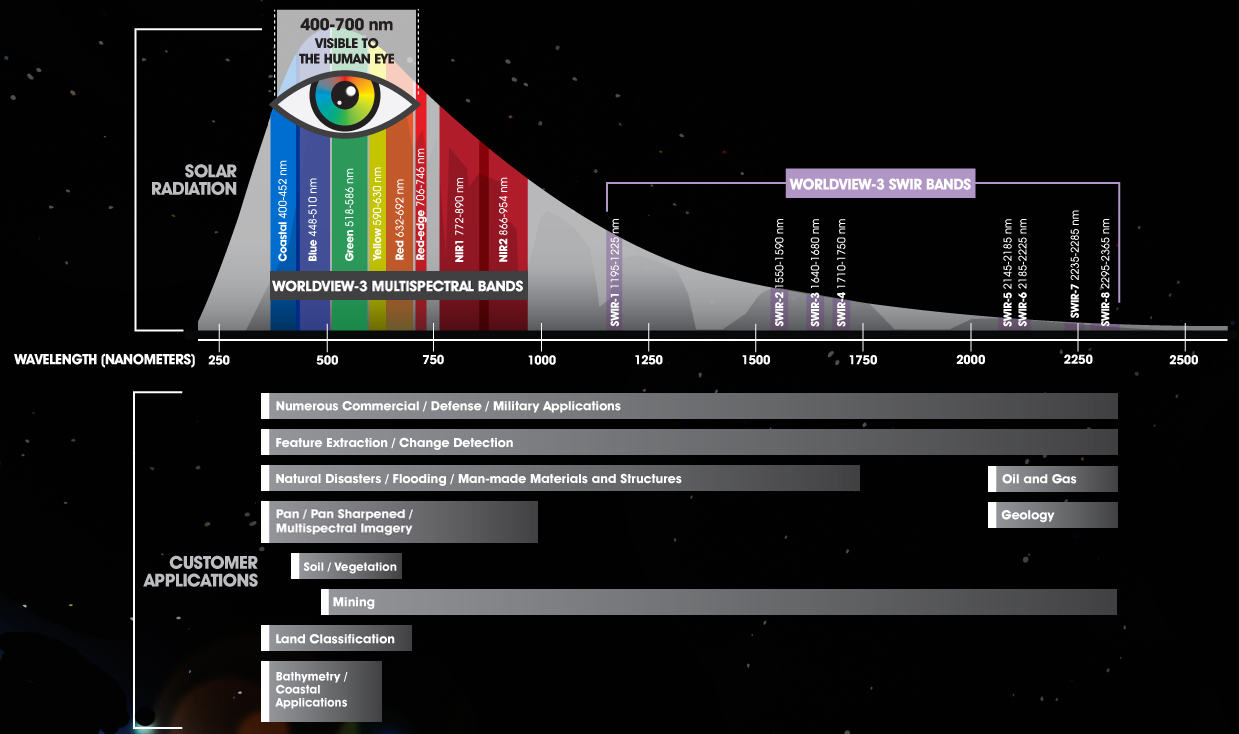

In [3]:
Image('worldview-3-spectral-bands.jpg', width="1000",embed=True)

In addition to satellite images, training data for 25 of the image locations is provided.  The training data are georeferenced polygon files containing classified objects found in the 25 different images.

The data for this problem can be downloaded at www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data

### ANALYZES

As mentioned earlier the 8-multispectral images contain 8 bands that have caputures image data at specific frequencies across the electromagnetic spectrum.  This allowes for data to be captures that might not be visible to the human eye.  For example, looking at the RGB image below-left we see a football field with grass.  However when examaning the image using near-Infrared we can determine that the field is actually made of artificial turf.

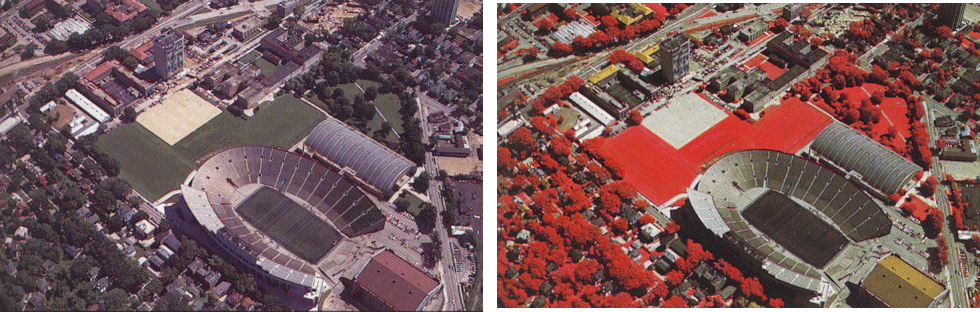

In [4]:
Image('9788139_orig.png', embed=True)

Therefore, instead of just using the red, green and blue colors we get from traditional images, we will want to use  the information of all 8 bands as they give different information.

## <center>Transforming and Formatting Data</center>

The first step of the analyzes was to convert the 25 satellite images that had test data to the format needed for the analysis.  The polygon files with the test data had to first be rasterized to the same resolution as the satelite images.  The satellite images and the test data were then transformed to a data matrix where rows contain image name, row, column, band, and test data data for pixels.

In [22]:


#----------------FUNCTION: Import satellite images----------------------------------------------------------------------#


def importsatimage(imagename):
    
    imagenameM = imagename + "_M.tif"    
    #print imagenameM
    satM = gdal.OpenShared(os.path.join('sixteen_band/',imagenameM),gdalconst.GA_Update)
    
        # Open the data source and read in the extent
    
    if os.path.isfile('sixteen_band/'+imagenameM):
        satM = gdal.OpenShared(os.path.join('sixteen_band/',imagenameM),gdalconst.GA_Update)
    else:
        raise IOError('Could not find file ' + imagenameM)
    if satM is None:
        raise IOError('Could open file ' + str(satM))
        
    return satM

#---------------FUNCTION: Convert Geotiff files to numpy arrays, resize the arrays same size---------------------------#

def geotiff2numpy(sat, dir):

    L1 = np.array(sat.GetRasterBand(1).ReadAsArray(),dtype=np.int16)
    L2 = np.array(sat.GetRasterBand(2).ReadAsArray(),dtype=np.int16)
    L3 = np.array(sat.GetRasterBand(3).ReadAsArray(),dtype=np.int16)
    L4 = np.array(sat.GetRasterBand(4).ReadAsArray(),dtype=np.int16)
    L5 = np.array(sat.GetRasterBand(5).ReadAsArray(),dtype=np.int16)
    L6 = np.array(sat.GetRasterBand(6).ReadAsArray(),dtype=np.int16)
    L7 = np.array(sat.GetRasterBand(7).ReadAsArray(),dtype=np.int16)
    L8 = np.array(sat.GetRasterBand(8).ReadAsArray(),dtype=np.int16)
 
    #convert bands in XYZ format
    
    row,col = L1.shape
    R,C = np.mgrid[:row,:col]
    
    name = np.full((row*col, 1), dir, dtype=np.dtype('a8'))
    nameCR = np.column_stack((name, C.ravel(),R.ravel()))
    nameCR = nameCR.astype('a8')

    XYLbands = np.column_stack((L1.ravel(),L2.ravel(),L3.ravel(),L4.ravel(),L5.ravel(),L6.ravel(),L7.ravel(),L8.ravel() ))

    return XYLbands, nameCR

#-----------------FUNCTION: Import polygon files and reproject them----------------------------------------------------#

def importpolygons(dir, file, M_col, M_row, x_max, y_min):
    
    polygonfilename = 'train_geojson_v3/' + dir + '/' + file

    # Define pixel_size and NoData value of new raster

    NoData_value = 255

    # Open the data source and read in the extent
    
    polygonfile = ogr.Open(polygonfilename)
    
    if os.path.isfile(polygonfilename):
        polygon = ogr.Open(polygonfilename)
    else:
        raise IOError('Could not find file ' + polygonfilename)
    if polygon is None:
        raise IOError('Could open file ' + str(polygon))
    
    polygon_layer = polygon.GetLayer()
    polygon_srs = polygon_layer.GetSpatialRef()
    x_min = 0
    y_max = 0
    
    if x_max == 999:
        x_min, x_max, y_min, y_max = polygon_layer.GetExtent()
    pixel_sizex = x_max/M_col
    pixel_sizey = y_min/M_row

    # Create the destination data source
    
    x_res = int((x_max - x_min) / pixel_sizex)
    y_res = -1*int((y_max - y_min) / pixel_sizey)
    target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
    target_ds.SetGeoTransform((0, pixel_sizex, 0, 0, 0, pixel_sizey))
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)

    # Rasterize the Polygon file
    
    gdal.RasterizeLayer(target_ds, [1], polygon_layer, burn_values=[1])
    
    array = band.ReadAsArray()
    classified = array.ravel()
    
    return classified, x_max, y_min

#-----------------FUNCTION: Assign an ID to the polygon file names-----------------------------------------------------#

def referenceID():

    reference = {}
    with open('TRAINING_REFERENCE.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            reference[row['NAME']] = int(row['UNIQUEID'])

    return reference

#-----------------FUNCTION: Read all vegetation polygon files and convert them to a data matrix------------------------#

def vegetation_classifications(parentdir,dir, reference, M_col, M_row):
    
    
    
    for _, _, files in os.walk(os.path.join(parentdir, dir)):
        
        files.sort(reverse=True)

        class_matrix = np.zeros((M_col*M_row,5),dtype=np.int16)
    
        for file in files:              
                                
            if 'Grid' in file:

                gridarray, x_max, y_min = importpolygons(dir, file, M_col, M_row, 999, -999)

            elif 'VEG' in file:
                    
                ID = reference[file]-18
                class_matrix[:,ID], x, y = importpolygons(dir, file, M_col, M_row, x_max, y_min)
            
    return class_matrix 


#-----------------FUNCTION: Convert Data-------------------------------------------------------------------------------#




#-----------------FUNCTION: Read in data it to a data matrix format----------------------------------------------------#

def dataintomatrix():
    
    data_matrix = None
    vegetation_matrix = None
    satsize = {}


    reference = referenceID()
    
# read which images have test data

    for parentdir, dirs, _ in os.walk('./train_geojson_v3/'):

# read in all satellite images that have test data and store the pixels in a data_matrix
        for dir in dirs:
        
            ImgM = importsatimage(dir)            
            M_row = ImgM.RasterYSize
            M_col = ImgM.RasterXSize
            satsize[dir] = M_row, M_col
        
# Create a data matrix with satellite band information for each pixel        

            if data_matrix is None:
 
                data_matrix, nameCR_matrix = geotiff2numpy(ImgM, dir)
    
            else:
                add2datamatrix, add2name = geotiff2numpy(ImgM, dir)
                data_matrix = np.concatenate((data_matrix, add2datamatrix),axis=0)
                nameCR_matrix = np.concatenate((nameCR_matrix, add2name),axis=0)

# Create a vegetation data matrix for each pixel  

            veg_matrix = vegetation_classifications(parentdir,dir, reference, M_col, M_row)   

            if vegetation_matrix is None:
 
                vegetation_matrix = veg_matrix
    
            else:

                vegetation_matrix = np.concatenate((vegetation_matrix, veg_matrix),axis=0)

#pickle up the data:

    file = open('data_matrix.p', 'w')
    pickle.dump(data_matrix, file)
    file.close()

    file = open('vegetation_matrix.p', 'w')
    pickle.dump(vegetation_matrix, file)
    file.close()
    
    file = open('nameCR_matrix.p', 'w')
    pickle.dump(nameCR_matrix, file)
    file.close()
    
    return 

#----------------------------------------------------------------------------------------------------------------------#
#----------------------------------------------------------------------------------------------------------------------#


dataintomatrix()

## <center>Pre-processing Data</center>
### Standardize data



The data from the bands was standized to ensure that each band was using the same scale so that the data from every band contributes equaly to the analysis.  The standardized data ($x_s$) was calculated by subtracting the band's mean ($\mu$) from each value ($x$) and dividing by the band's standard deviation ($\sigma$) as shown in the equation below:

$$x_s=\frac{x -\mu}{\sigma}$$

In [23]:
def NDVI(datamatrix):
    datamatrix = datamatrix.astype(np.float64)
    NDVI = np.matrix((datamatrix[:,7]-datamatrix[:,4])/(datamatrix[:,7]+datamatrix[:,4])).T
    NDVI = NDVI.astype(np.float16)
    file = open('NDVI.p', 'w')
    pickle.dump(NDVI, file)
    file.close()
    return

def standardizedata(datamatrix):
    r,c = datamatrix.shape
    datamatrix = datamatrix.astype(np.float64)
    for n in range(0,c):
        datamatrix[:,n] = preprocessing.scale(datamatrix[:,n])
    datamatrix = datamatrix.astype(np.float16)
    return datamatrix



def preprocessingdata():
    file = open('data_matrix.p', 'r')
    datamatrix = pickle.load(file)
    file.close()
    NDVI(datamatrix)
    standardized_matrix = standardizedata(datamatrix)
    
    file = open('standardized_matrix.p', 'w')
    pickle.dump(standardized_matrix, file)
    file.close()
    
    return

preprocessingdata()


### Create Balanced Train and Test Dataset

The 25 satelite images have a total of 17748583 pixels. The table below summarizes the number of data types that are found in the dataset.

| type | pixels | percent |
|-------|
|trees | 1689634 | 9.52% |
|woodland | 104328 | 0.59% |
|shrubland | 2386073 | 13.44% |
|other | 13568548 | 76.45% |
|total | 17748583 ||

The dataset is highly imbalenced.  For example, only 0.59% of these pixels are defined as woodland while 75.45% of these pixels are defined as other.  When creating a random training and test dataset, there is a good change that the model will overfir *other* and that not enough woodland data is included in the training dataset to develop a good woodland classifier.  To avoid this issue, a balance training and testing dataset was created using random stratisfied sampling.  80,000 and 20,000 random data points were taken from each data type to create the training and test dataset, repectively.

In [30]:
#-----------------FUNCTION: Convert Data-------------------------------------------------------------------------------#

def convertvegdata():

    file = open('vegetation_matrix.p', 'r')
    vegetation_matrix = pickle.load(file)
    file.close()
#
    num_rows,_ = vegetation_matrix.shape

    y = np.empty([num_rows, 1],dtype=np.int16)
    t = w = s = o = 0
    for n in range(0,num_rows):
        if vegetation_matrix[n,4] == 1 or vegetation_matrix[n,3] == 1:
            y[n]=1
            t = t+1
        elif vegetation_matrix[n,1] == 1:
            y[n]=2
            w = w+1
        elif vegetation_matrix[n,0] == 1:
            y[n]=3
            s = s+1
        else:
            y[n]=0
            o = o +1
    return y, t, w, s, o, num_rows

def combinedatasets(targets):
    
    file = open('standardized_matrix.p', 'r')
    standardized_matrix = pickle.load(file)
    file.close()
    alldata = np.concatenate((standardized_matrix,targets),axis=1)
    alldata = alldata.astype(np.float16)
    
    return alldata

def combinedata():

    target, numtrees, numwood, numshrub, numother, total = convertvegdata()
    alldata = combinedatasets(target)

    file = open('alldata.p', 'w')
    pickle.dump(alldata, file)
    file.close()
    
    return
combinedata()

In [31]:
def woodland(alldata):
    alldata = np.array(alldata)
    woodland = alldata[alldata[:,8] == 2]
    notwoodland = alldata[alldata[:,8] != 2]
    file = open('woodland.p', 'w')
    pickle.dump(woodland , file)
    file.close()
    file = open('notwoodland.p', 'w')
    pickle.dump(notwoodland , file)
    file.close()
    return
    
def shrubland(alldata):
    alldata = np.array(alldata)
    shrubland = alldata[alldata[:,8] == 3]
    notshrubland = alldata[alldata[:,8] != 3]
    file = open('shrubland.p', 'w')
    pickle.dump(shrubland, file)
    file.close()
    file = open('notshrubland.p', 'w')
    pickle.dump(notshrubland, file)
    file.close()
    return
def trees(alldata):
    alldata = np.array(alldata)
    trees = alldata[alldata[:,8] == 1]
    nottrees = alldata[alldata[:,8] != 1]
    file = open('trees.p', 'w')
    pickle.dump(trees, file)
    file.close()
    file = open('nottrees.p', 'w')
    pickle.dump(nottrees, file)
    file.close()
    return
def other(alldata):
    alldata = np.array(alldata)
    other = alldata[alldata[:,8] == 0]
    file = open('other.p', 'w')
    pickle.dump(other, file)
    file.close()
    return

def createvegtypefiles():
    file = open('alldata.p', 'r')
    alldata = pickle.load(file)
    file.close()
    woodland(alldata)
    shrubland(alldata)
    trees(alldata)
    other(alldata)
    return

createvegtypefiles()

In [32]:
def woodlandsamples():
      
    file = open('notwoodland.p', 'r')
    notwoodland = pickle.load(file)
    file.close()

    file = open('woodland.p', 'r')
    woodland = pickle.load(file)
    file.close()

    r,c = woodland.shape
    testpercent = 1 - 80000/float(r)
    wood_xtrain, wood_xtest, wood_ytrain, wood_ytest = train_test_split(woodland[:,0:8], woodland[:,8], test_size=testpercent, random_state=0)
    r,c = wood_xtest.shape
    testpercent = 20000/float(r)
    _, wood_xtest,_, wood_ytest= train_test_split(wood_xtest, wood_ytest, test_size=testpercent, random_state=0)
    
    return wood_xtrain, wood_ytrain, wood_xtest, wood_ytest

def shrublandsamples():
    
    file = open('shrubland.p', 'r')
    shrubland = pickle.load(file)
    file.close()
    
    file = open('notshrubland.p', 'r')
    notshrubland = pickle.load(file)
    file.close()
    
    r,c = shrubland.shape
    testpercent = 1 - 80000/float(r)
    shrub_xtrain, shrub_xtest, shrub_ytrain, shrub_ytest = train_test_split(shrubland[:,0:8], shrubland[:,8], test_size=testpercent, random_state=500)
    r,c = shrub_xtest.shape
    testpercent = 20000/float(r)
    _, shrub_xtest,_, shrub_ytest= train_test_split(shrub_xtest, shrub_ytest, test_size=testpercent, random_state=0)
    
    return shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest

def treessamples():
    
    file = open('trees.p', 'r')
    trees = pickle.load(file)
    file.close()

    file = open('nottrees.p', 'r')
    nottrees = pickle.load(file)
    file.close()
    
    r,c = trees.shape
    testpercent = 1 - 80000/float(r)
    tree_xtrain, tree_xtest, tree_ytrain, tree_ytest = train_test_split(trees[:,0:8], trees[:,8], test_size=testpercent, random_state=0)
    r,c = tree_xtest.shape
    testpercent = 20000/float(r)
    _, tree_xtest,_, tree_ytest= train_test_split(tree_xtest, tree_ytest, test_size=testpercent, random_state=0)
  
    return tree_xtrain, tree_ytrain, tree_xtest, tree_ytest

def othersamples():
    
    file = open('other.p', 'r')
    other = pickle.load(file)
    file.close()
    
    r,c = other.shape
    testpercent = 1 - 80000/float(r)
    other_xtrain, other_xtest, other_ytrain, other_ytest = train_test_split(other[:,0:8], other[:,8], test_size=testpercent, random_state=0)    
    r,c = other_xtest.shape
    testpercent = 20000/float(r)
    _, other_xtest,_, other_ytest= train_test_split(other_xtest[:,0:8], other_ytest, test_size=testpercent, random_state=0)

    return other_xtrain, other_ytrain, other_xtest, other_ytest

def modeldata(wood_xtrain, wood_ytrain, wood_xtest, wood_ytest, shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest, \
            tree_xtrain, tree_ytrain, tree_xtest, tree_ytest, other_xtrain, other_ytrain, other_xtest, other_ytest ):
    
    x_train = np.concatenate((wood_xtrain,shrub_xtrain,tree_xtrain,other_xtrain),axis=0)
    y_train = np.concatenate((wood_ytrain,shrub_ytrain,tree_ytrain,other_ytrain),axis=0)
    x_test = np.concatenate((wood_xtest,shrub_xtest,tree_xtest,other_xtest),axis=0)
    y_test = np.concatenate((wood_ytest,shrub_ytest,tree_ytest,other_ytest),axis=0)
    
    rtest = len(y_test)
    rtrain = len(y_train)
    
    y_train_matrix = np.empty([rtrain, 4],dtype=np.int16)
    y_test_matrix = np.empty([rtest, 4],dtype=np.int16)
    
    for i in range(0,rtrain):
        if y_train[i] == 0:
            y_train_matrix[i,:] = [1,0,0,0]
        elif y_train[i] == 1:
            y_train_matrix[i,:] = [0,1,0,0]
        elif y_train[i] == 2:
            y_train_matrix[i,:] = [0,0,1,0]
        else:
            y_train_matrix[i,:] = [0,0,0,1]
            
    for i in range(0,rtest):       
        if y_test[i] == 0:
            y_test_matrix[i,:] = [1,0,0,0]
        elif y_test[i] == 1:
            y_test_matrix[i,:] = [0,1,0,0]
        elif y_test[i] == 2:
            y_test_matrix[i,:] = [0,0,1,0]
        else:
            y_test_matrix[i,:] = [0,0,0,1] 
    
    file = open('x_train.p', 'w')
    pickle.dump(x_train , file)
    file.close()
    
    file = open('y_train.p', 'w')
    pickle.dump(y_train , file)
    file.close()
    
    file = open('x_test.p', 'w')
    pickle.dump(x_test , file)
    file.close()
    
    file = open('y_test.p', 'w')
    pickle.dump(y_test , file)
    file.close()
    
    file = open('y_test_matrix.p', 'w')
    pickle.dump(y_test_matrix , file)
    file.close()
    
    file = open('y_train_matrix.p', 'w')
    pickle.dump(y_train_matrix , file)    
    file.close()
       
    return



def createsampledata():

    wood_xtrain, wood_ytrain, wood_xtest, wood_ytest = woodlandsamples()
    
    shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest = shrublandsamples()
    
    tree_xtrain, tree_ytrain, tree_xtest, tree_ytest = treessamples()
    
    other_xtrain, other_ytrain, other_xtest, other_ytest = othersamples()
    
    modeldata(wood_xtrain, wood_ytrain, wood_xtest, wood_ytest, shrub_xtrain, shrub_ytrain, shrub_xtest, shrub_ytest, \
            tree_xtrain, tree_ytrain, tree_xtest, tree_ytest, other_xtrain, other_ytrain, other_xtest, other_ytest )
        
    return

createsampledata()

## <center> **Model Classifiers **</center>

Four model classfiers were developed, a knn model, a random forest model and two svm models both using 'rbf' kernels.  All models used the same training and test dataset.  The random forest model was relatively fast to develop and run.  Both svm models were relativly slow to develop and took the longest to run.

In [60]:
file = open('x_train.p', 'r')
x_train = pickle.load(file)
file.close()
    
file = open('y_train.p', 'r')
y_train = pickle.load(file)
file.close()
    
file = open('x_test.p', 'r')
x_test = pickle.load(file)
file.close()
    
file = open('y_test.p', 'r')
y_test = pickle.load(file)
file.close()

### KNN Classifier

In [143]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [149]:
file = open('knn.p', 'w')
pickle.dump(knn, file)
file.close()

In [ ]:
file = open('knn.p', 'r')
knn = pickle.load(file)
file.close()

In [144]:
knny_train = knn.predict(x_train)

In [145]:
knnmatrix_trainy = confusion_matrix(y_train, knny_train)

In [146]:
knny_test = knn.predict(x_test)

In [147]:
knn_testscore = knn.predict_proba(x_test)

In [148]:
knnmatrix_testy = confusion_matrix(y_test, knny_test)

In [158]:
file = open('knnmatrix_trainy.p', 'w')
pickle.dump(knnmatrix_trainy, file)
file.close()

file = open('knnmatrix_testy.p', 'w')
pickle.dump(knnmatrix_testy, file)
file.close()

file = open('knn_testscore.p', 'w')
pickle.dump(knn_testscore, file)
file.close()

### SVM Classifiers

#### One Versus One Classifier

In [213]:
ovo_svm = SVC(probability=True)
ovo_svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [214]:
file = open('ovo_svm.p', 'w')
pickle.dump(ovo_svm, file)
file.close()

In [215]:
file = open('ovo_svm.p', 'r')
ovo_svm = pickle.load(file)
file.close()

In [216]:
ovo_svm_train = ovo_svm.predict(x_train)

In [217]:
ovo_svmmatrix_trainy = confusion_matrix(y_train, ovo_svm_train)

In [218]:
ovo_svm_test = ovo_svm.predict(x_test)

In [219]:
ovo_svm_testscore = ovo_svm.predict_proba(x_test)

In [220]:
ovo_svmmatrix_testy = confusion_matrix(y_test, ovo_svm_test)

In [221]:
file = open('ovo_svmmatrix_trainy.p', 'w')
pickle.dump(ovo_svmmatrix_trainy, file)
file.close()

file = open('ovo_svmmatrix_testy.p', 'w')
pickle.dump(ovo_svmmatrix_testy, file)
file.close()

file = open('ovo_svm_testscore.p', 'w')
pickle.dump(ovo_svm_testscore, file)
file.close()

#### One Versus Rest Classifier

In [168]:
ovr_svm = OneVsRestClassifier(SVC())
ovr_svm.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [169]:
file = open('ovr_svm.p', 'w')
pickle.dump(ovr_svm, file)
file.close()

In [170]:
file = open('ovr_svm.p', 'r')
ovr_svm = pickle.load(file)
file.close()

In [171]:
ovr_svm_train = ovr_svm.predict(x_train)

In [172]:
ovr_svmmatrix_trainy = confusion_matrix(y_train, ovr_svm_train)

In [173]:
ovr_svm_test = ovr_svm.predict(x_test)


In [174]:
ovr_svm_testscore = ovr_svm.decision_function(x_test)

In [175]:
ovr_svmmatrix_testy = confusion_matrix(y_test, ovr_svm_test)

In [177]:
file = open('ovr_svmmatrix_trainy.p', 'w')
pickle.dump(ovr_svmmatrix_trainy, file)
file.close()

file = open('ovr_svmmatrix_testy.p', 'w')
pickle.dump(ovr_svmmatrix_testy, file)
file.close()

file = open('ovr_svm_testscore.p', 'w')
pickle.dump(ovr_svm_testscore, file)
file.close()

### Random Forest
Random forests or random decision forests[1][2] are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.[3]:587–588

In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets, i.e. have low bias, but very high variance. Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance.[3]:587–588 This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance.

fastest

In [61]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
forest_trainy = forest.predict(x_train)

In [63]:
forest_trainscore = forest.predict_proba(x_train)

In [64]:
r, c = forest_trainscore.shape
print r, c

319999 4


In [65]:
forestmatrix_trainy = confusion_matrix(y_train, forest_trainy)

In [66]:
forest_testy = forest.predict(x_test)

In [67]:
forest_testscore = forest.predict_proba(x_test)

In [68]:
forestmatrix_testy = confusion_matrix(y_test, forest_testy)

In [69]:
file = open('forest.p', 'w')
pickle.dump(forest, file)
file.close()

## <center>Model Classifier Comparison</center>

After the models were developed and run confusion matrixes, ROC curves and PR curves were created.

### confusion matrix



In [222]:
file = open('knnmatrix_trainy.p', 'r')
knnmatrix_trainy = pickle.load(file)
file.close()

file = open('knnmatrix_testy.p', 'r')
knnmatrix_testy = pickle.load(file)
file.close()

file = open('knn_testscore.p', 'r')
knn_testscore = pickle.load(file)
file.close()

file = open('ovo_svmmatrix_trainy.p', 'r')
ovo_svmmatrix_trainy = pickle.load(file)
file.close()

file = open('ovo_svmmatrix_testy.p', 'r')
ovo_svmmatrix_testy = pickle.load(file)
file.close()

file = open('ovo_svm_testscore.p', 'r')
ovo_svm_testscore = pickle.load(file)
file.close()

file = open('ovr_svmmatrix_trainy.p', 'r')
ovr_svmmatrix_trainy = pickle.load(file)
file.close()

file = open('ovr_svmmatrix_testy.p', 'r')
ovr_svmmatrix_testy = pickle.load(file)
file.close()

file = open('ovr_svm_testscore.p', 'r')
ovr_svm_testscore = pickle.load(file)
file.close()



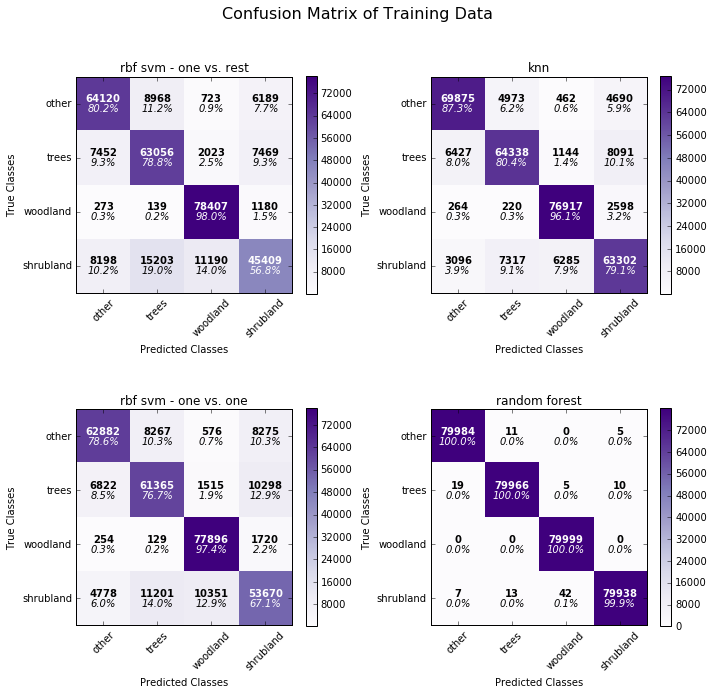

In [223]:
#---------------This function prints and plots the confusion matrix---------------------------------------
#--------------------------Code taken and Modified from: -------------------------------------------------
#-------http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html-----------

def plot_confusion_matrix(confmatrix, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):

    plt.imshow(confmatrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.6)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
        
    cmnorm = np.around((100*confmatrix.astype('float') / confmatrix.sum(axis=1)),1)    

    thresh = confmatrix.max() / 2.
    for i, j in itertools.product(range(confmatrix.shape[0]), range(confmatrix.shape[1])):
        plt.text(j, i, confmatrix[i, j],
                 horizontalalignment="center", verticalalignment="bottom",
                 color="white" if confmatrix[i, j] > thresh else "black", fontsize=10, weight="bold")
        percent = str(cmnorm[i, j]) + "%"
        plt.text(j, i, percent,
                 horizontalalignment="center", verticalalignment="top",
                 color="white" if confmatrix[i, j] > thresh else "black", fontsize=10, style="italic")
        

    plt.tight_layout()
    plt.ylabel('True Classes')
    plt.xlabel('Predicted Classes')

class_names = ['other','trees','woodland','shrubland']

plt.close('all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax1 = plt.subplot(221)
plot_confusion_matrix(ovr_svmmatrix_trainy, classes=class_names, title='rbf svm - one vs. rest')
ax2 = plt.subplot(222)
plot_confusion_matrix(knnmatrix_trainy, classes=class_names,title='knn')
ax3 = plt.subplot(223)
plot_confusion_matrix(ovo_svmmatrix_trainy, classes=class_names,title='rbf svm - one vs. one')
ax4 = plt.subplot(224)
plot_confusion_matrix(forestmatrix_trainy, classes=class_names,title='random forest')

plt.suptitle('Confusion Matrix of Training Data', fontsize=16)
plt.show()


training data: random forest shows the best results all classes have been classsified with a 99.9% accuracy-- random forest overfits data.
all models show that woodland class is classified the best
shrubland shows the least accurate classification
false positives

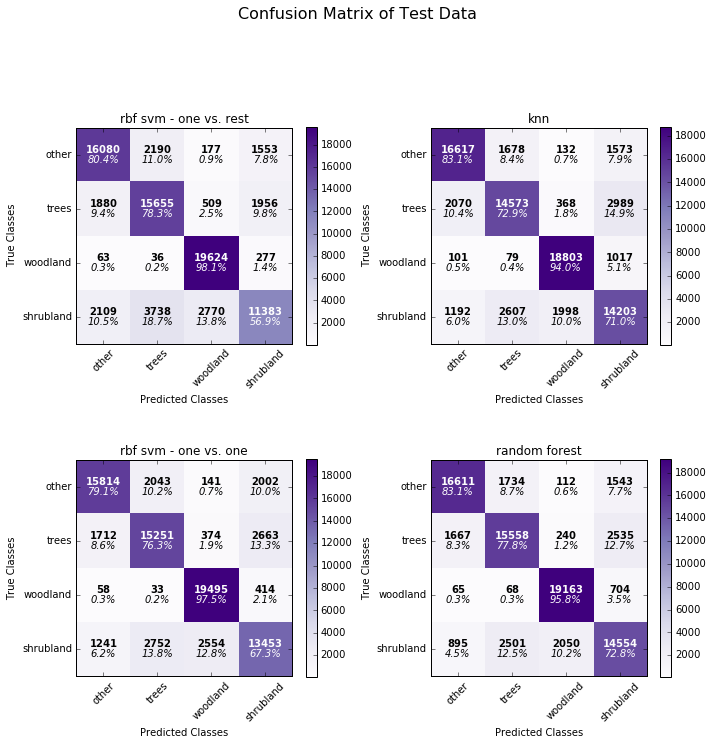

In [224]:
plt.close('all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax1 = plt.subplot(221)
plot_confusion_matrix(ovr_svmmatrix_testy, classes=class_names, title='rbf svm - one vs. rest')
ax2 = plt.subplot(222)
plot_confusion_matrix(knnmatrix_testy, classes=class_names,title='knn')
ax3 = plt.subplot(223)
plot_confusion_matrix(ovo_svmmatrix_testy, classes=class_names,title='rbf svm - one vs. one')
ax4 = plt.subplot(224)
plot_confusion_matrix(forestmatrix_testy, classes=class_names,title='random forest')

plt.suptitle('Confusion Matrix of Test Data', y=1.05, fontsize=16)
plt.show()

training data: as its overfit...as expected less accurate than the training data set.
all models show that woodland class is classified the best
shrubland shows the least accurate classification
false positives

### ROC Curves



In [226]:
file = open('y_test_matrix.p', 'r')
y_test_matrix = pickle.load(file)
file.close()
    
file = open('y_train_matrix.p', 'r')
y_train_matrix = pickle.load(file)
file.close()

_, n_classes = y_test_matrix.shape

In [234]:
def ROC(y_test_matrix, y_score, n_classes):

    
    false_positive_rate = dict()
    true_positive_rate = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_test_matrix[:, i], y_score[:, i])
        roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])
 
    # Compute micro-average ROC curve and ROC area
    false_positive_rate["micro"], true_positive_rate["micro"], _ = roc_curve(y_test_matrix.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(false_positive_rate["micro"], true_positive_rate["micro"])
    
   
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_false_positive_rate = np.unique(np.concatenate([false_positive_rate[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_true_positive_rate = np.zeros_like(all_false_positive_rate)
    for i in range(n_classes):
        mean_true_positive_rate += interp(all_false_positive_rate, false_positive_rate[i], true_positive_rate[i])

    # Finally average it and compute AUC
    mean_true_positive_rate /= n_classes

    false_positive_rate["macro"] = all_false_positive_rate
    true_positive_rate["macro"] = mean_true_positive_rate
    roc_auc["macro"] = auc(false_positive_rate["macro"], true_positive_rate["macro"])

    return roc_auc, true_positive_rate, false_positive_rate


roc_auc_forest, true_pos_rate_forest, false_pos_rate_forest =  ROC(y_test_matrix, forest_testscore, n_classes)
roc_auc_ovosvm, true_pos_rate_ovosvm, false_pos_rate_ovosvm =  ROC(y_test_matrix, ovo_svm_testscore, n_classes) 
roc_auc_ovrsvm, true_pos_rate_ovrsvm, false_pos_rate_ovrsvm =  ROC(y_test_matrix, ovr_svm_testscore, n_classes)
roc_auc_knn, true_pos_rate_knn, false_pos_rate_knn =  ROC(y_test_matrix, knn_testscore, n_classes)


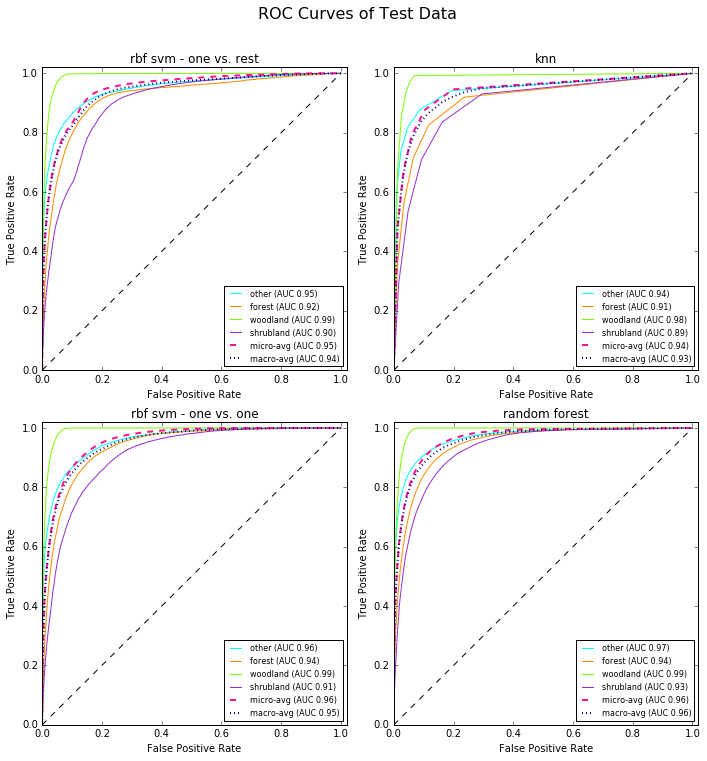

In [235]:

def rocplot(false_positive_rate, true_positive_rate, roc_auc, n_classes, title='ROC Curve'):
    # Plot all ROC curves
    classname = ('other','forest','woodland', 'shrubland')

    colors = cycle(['aqua', 'darkorange', 'lawngreen', 'darkorchid'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=1,
                 label='{0} (AUC {1:0.2f})'.format(classname[i], roc_auc[i]))
    
    plt.plot(false_positive_rate["micro"], true_positive_rate["micro"],
             label='micro-avg (AUC {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle='--', linewidth=2)

    plt.plot(false_positive_rate["macro"], true_positive_rate["macro"],
             label='macro-avg (AUC {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2)
    plt.tight_layout()
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.02])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right",prop={'size':8})

plt.close('all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax1 = plt.subplot(221)
rocplot(false_pos_rate_ovrsvm, true_pos_rate_ovrsvm,roc_auc_ovrsvm, n_classes, 'rbf svm - one vs. rest' )
ax2 = plt.subplot(222)
rocplot(false_pos_rate_knn, true_pos_rate_knn,roc_auc_knn, n_classes, 'knn' )
ax3 = plt.subplot(223)
rocplot(false_pos_rate_ovosvm, true_pos_rate_ovosvm,roc_auc_ovosvm, n_classes, 'rbf svm - one vs. one' )
ax4 = plt.subplot(224)
rocplot(false_pos_rate_forest, true_pos_rate_forest,roc_auc_forest, n_classes, 'random forest' )

plt.suptitle('ROC Curves of Test Data', y=1.05, fontsize=16)

plt.show()

shrubland knn auc 0.89
woodland auc at least .98
best macro-avg 0.96 worst 0.93

### Precision-Recall

In [236]:
def Precision_Recall(y_test_matrix, y_score, n_classes):
    
    
    # Compute Precision-Recall and plot curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_matrix[:, i],
                                                        y_score[:, i])
        average_precision[i] = average_precision_score(y_test_matrix[:, i], y_score[:, i])
        # Compute micro-average ROC curve and ROC area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_matrix.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test_matrix, y_score,
                                                     average="micro")
    return precision, recall, average_precision

precision_forest, recall_forest, average_forest =  Precision_Recall(y_test_matrix, forest_testscore, n_classes)
precision_ovosvm, recall_ovosvm, average_ovosvm =  Precision_Recall(y_test_matrix, ovo_svm_testscore, n_classes) 
precision_ovrsvm, recall_ovrsvm, average_ovrsvm =  Precision_Recall(y_test_matrix, ovr_svm_testscore, n_classes)
precision_knn, recall_knn, average_knn =  Precision_Recall(y_test_matrix, knn_testscore, n_classes)

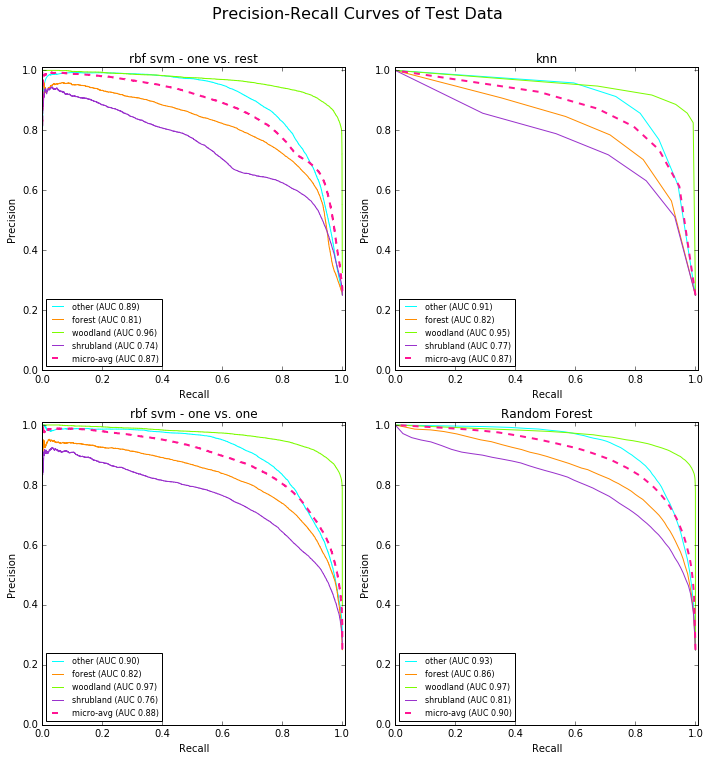

In [238]:
def plotPR(precision, recall,average_precision, n_classes, title='PR Curve'):

    # Plot Precision-Recall curve for each class
    classname = ('other','forest','woodland', 'shrubland')
    colors = cycle(['aqua', 'darkorange', 'lawngreen', 'darkorchid'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], label='{0} (AUC {1:0.2f})'.format(classname[i], average_precision[i])
                 , color=color, lw=1)
    plt.plot(recall["micro"], precision["micro"], label='micro-avg (AUC {0:0.2f})'
             .format(average_precision["micro"]),color='deeppink', linestyle='--', linewidth=2)
        
    plt.tight_layout()
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left",prop={'size':8})

plt.close('all')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax1 = plt.subplot(221)
plotPR(precision_ovrsvm, recall_ovrsvm,average_ovrsvm, n_classes, 'rbf svm - one vs. rest' )
ax2 = plt.subplot(222)
plotPR(precision_knn, recall_knn,average_knn, n_classes,'knn')
ax3 = plt.subplot(223)
plotPR(precision_ovosvm, recall_ovosvm,average_ovosvm, n_classes,'rbf svm - one vs. one')
ax4 = plt.subplot(224)
plotPR(precision_forest, recall_forest,average_forest, n_classes,'Random Forest')

plt.suptitle('Precision-Recall Curves of Test Data', y=1.05, fontsize=16)

plt.show()

## <center>Classifying Satelite Images</center>
Four satellite images with different types of landuses were chosen to perform a visual inspection and determine how well the different classifier models worked.  After the models were run on the pixels of a satellite image. the resulting data  was transformed to a 2-dimensional data and then converted and resized to a geotiff image.  QGIS was used to visualize the satellite and classified geotiff images.
The first satellite image compares the knn, random forest, and one-vs-rest svm models to the original classified image.  The other four satellite images only compared the knn and random forest models to reduce porcessing time.  

In [2]:
#file = open('data_matrix.p', 'r')
#data_matrix = pickle.load(file)
#file.close()

file = open('alldata.p', 'r')
alldata = pickle.load(file)
file.close()
    
file = open('nameCR_matrix.p', 'r')
nameCR_matrix = pickle.load(file)
file.close()

file = open('knn.p', 'r')
knn = pickle.load(file)
file.close()

file = open('ovo_svm.p', 'r')
ovo_svm = pickle.load(file)
file.close()

file = open('ovr_svm.p', 'r')
ovr_svm = pickle.load(file)
file.close()

file = open('forest.p', 'r')
forest = pickle.load(file)
file.close()

In [3]:
r,_ = nameCR_matrix.shape

n1=0
n2=0
n3=0
n4=0
n5=0

i6070_2_3 = np.empty([838*835,12], dtype=np.object_)
i6090_2_0 = np.empty([837*848,12], dtype=np.object_)
i6100_2_2 = np.empty([837*848,12], dtype=np.object_)
i6150_2_3 = np.empty([837*851,12], dtype=np.object_)
i6170_0_4 = np.empty([837*848,12], dtype=np.object_)

for i in range(r):
    
    if nameCR_matrix[i,0] == '6070_2_3':

        i6070_2_3[n1,0]  = nameCR_matrix[i,0]        
        i6070_2_3[n1,1:3] = nameCR_matrix[i,1:3].astype(np.int16)        
        i6070_2_3[n1,3:12] = alldata[i,:]
        n1 = n1 + 1
        
    elif nameCR_matrix[i,0] == '6090_2_0':
        i6090_2_0[n2,0]  = nameCR_matrix[i,0]        
        i6090_2_0[n2,1:3] = nameCR_matrix[i,1:3].astype(np.int16)        
        i6090_2_0[n2,3:12] = alldata[i,:]
        n2 = n2 + 1
            
    elif nameCR_matrix[i,0] == '6100_2_2':

        i6100_2_2[n3,0]  = nameCR_matrix[i,0]        
        i6100_2_2[n3,1:3] = nameCR_matrix[i,1:3].astype(np.int16)        
        i6100_2_2[n3,3:12] = alldata[i,:]
        n3 = n3 + 1
            
    elif nameCR_matrix[i,0] == '6150_2_3':

        i6150_2_3[n4,0]  = nameCR_matrix[i,0]        
        i6150_2_3[n4,1:3] = nameCR_matrix[i,1:3].astype(np.int16)        
        i6150_2_3[n4,3:12] = alldata[i,:]
        n4 = n4 + 1
            
    elif nameCR_matrix[i,0] == '6170_0_4':

        i6170_0_4[n5,0]  = nameCR_matrix[i,0]        
        i6170_0_4[n5,1:3] = nameCR_matrix[i,1:3].astype(np.int16)        
        i6170_0_4[n5,3:12] = alldata[i,:]
        n5 = n5 + 1

In [14]:
forestclass_i6070_2_3 = np.empty([699730,3], dtype=np.int16)
forestclass_i6070_2_3[:,0]=i6070_2_3[:,1].astype(np.int16)
forestclass_i6070_2_3[:,1]=i6070_2_3[:,2].astype(np.int16)
forestclass_i6070_2_3[:,2] = forest.predict(i6070_2_3[:,3:11])

forestclass_i6090_2_0 = np.empty([837*848,3], dtype=np.int16)
forestclass_i6090_2_0[:,0]=i6090_2_0[:,1].astype(np.int16)
forestclass_i6090_2_0[:,1]=i6090_2_0[:,2].astype(np.int16)
forestclass_i6090_2_0[:,2] = forest.predict(i6090_2_0[:,3:11])

forestclass_i6100_2_2 = np.empty([837*848,3], dtype=np.int16)
forestclass_i6100_2_2[:,0]=i6100_2_2[:,1].astype(np.int16)
forestclass_i6100_2_2[:,1]=i6100_2_2[:,2].astype(np.int16)
forestclass_i6100_2_2[:,2] = forest.predict(i6100_2_2[:,3:11])

forestclass_i6150_2_3 = np.empty([837*851,3], dtype=np.int16)
forestclass_i6150_2_3[:,0]=i6150_2_3[:,1].astype(np.int16)
forestclass_i6150_2_3[:,1]=i6150_2_3[:,2].astype(np.int16)
forestclass_i6150_2_3[:,2] = forest.predict(i6150_2_3[:,3:11])

forestclass_i6170_0_4 = np.empty([837*848,3], dtype=np.int16)
forestclass_i6170_0_4[:,0]=i6170_0_4[:,1].astype(np.int16)
forestclass_i6170_0_4[:,1]=i6170_0_4[:,2].astype(np.int16)
forestclass_i6170_0_4[:,2] = forest.predict(i6170_0_4[:,3:11])

knnclass_i6070_2_3 = np.empty([699730,3], dtype=np.int16)
knnclass_i6070_2_3[:,0]=i6070_2_3[:,1].astype(np.int16)
knnclass_i6070_2_3[:,1]=i6070_2_3[:,2].astype(np.int16)
knnclass_i6070_2_3[:,2] = knn.predict(i6070_2_3[:,3:11])

knnclass_i6150_2_3 = np.empty([837*851,3], dtype=np.int16)
knnclass_i6150_2_3[:,0]=i6150_2_3[:,1].astype(np.int16)
knnclass_i6150_2_3[:,1]=i6150_2_3[:,2].astype(np.int16)
knnclass_i6150_2_3[:,2] = knn.predict(i6150_2_3[:,3:11])

knnclass_i6090_2_0 = np.empty([837*848,3], dtype=np.int16)
knnclass_i6090_2_0[:,0]=i6090_2_0[:,1].astype(np.int16)
knnclass_i6090_2_0[:,1]=i6090_2_0[:,2].astype(np.int16)
knnclass_i6090_2_0[:,2] = knn.predict(i6090_2_0[:,3:11])

knnclass_i6100_2_2 = np.empty([837*848,3], dtype=np.int16)
knnclass_i6100_2_2[:,0]=i6100_2_2[:,1].astype(np.int16)
knnclass_i6100_2_2[:,1]=i6100_2_2[:,2].astype(np.int16)
knnclass_i6100_2_2[:,2] = knn.predict(i6100_2_2[:,3:11])

knnclass_i6170_0_4 = np.empty([837*848,3], dtype=np.int16)
knnclass_i6170_0_4[:,0]=i6170_0_4[:,1].astype(np.int16)
knnclass_i6170_0_4[:,1]=i6170_0_4[:,2].astype(np.int16)
knnclass_i6170_0_4[:,2] = knn.predict(i6170_0_4[:,3:11])

In [5]:
ovo_svmclass_i6070_2_3 = np.empty([699730,3], dtype=np.int16)
ovo_svmclass_i6070_2_3[:,0]=i6070_2_3[:,1].astype(np.int16)
ovo_svmclass_i6070_2_3[:,1]=i6070_2_3[:,2].astype(np.int16)
ovo_svmclass_i6070_2_3[:,2] = ovo_svm.predict(i6070_2_3[:,3:11])

file = open('ovo_svmclass_i6070_2_3.p', 'w')
pickle.dump(ovo_svmclass_i6070_2_3, file)
file.close()

In [30]:
ovr_svmclass_i6070_2_3 = np.empty([699730,3], dtype=np.int16)
ovr_svmclass_i6070_2_3[:,0]=i6070_2_3[:,1].astype(np.int16)
ovr_svmclass_i6070_2_3[:,1]=i6070_2_3[:,2].astype(np.int16)
ovr_svmclass_i6070_2_3[:,2] = ovr_svm.predict(i6070_2_3[:,3:11])

file = open('ovr_svmclass_i6070_2_3.p', 'w')
pickle.dump(ovr_svmclass_i6070_2_3, file)
file.close()

In [15]:
file = open('ovo_svmclass_i6070_2_3.p', 'r')
ovo_svmclass_i6070_2_3 = pickle.load(file)
file.close()

file = open('ovr_svmclass_i6070_2_3.p', 'r')
ovr_svmclass_i6070_2_3 = pickle.load(file)
file.close()

In [36]:
forestmatrix_i6070_2_3 =  np.empty([838,835], dtype=np.int8)
forestmatrix_i6090_2_0 =  np.empty([837,848], dtype=np.int8)
forestmatrix_i6100_2_2 =  np.empty([837,848], dtype=np.int8)
forestmatrix_i6150_2_3 =  np.empty([837,851], dtype=np.int8)
forestmatrix_i6170_0_4 =  np.empty([837,848], dtype=np.int8)
ovr_svmmatrix_i6070_2_3 =  np.empty([838,835], dtype=np.int8)
ovo_svmmatrix_i6070_2_3 =  np.empty([838,835], dtype=np.int8)
knnmatrix_i6070_2_3 =  np.empty([838,835], dtype=np.int8)
knnmatrix_i6090_2_0 =  np.empty([837,848], dtype=np.int8)
knnmatrix_i6100_2_2 =  np.empty([837,848], dtype=np.int8)
knnmatrix_i6150_2_3 =  np.empty([837,851], dtype=np.int8)
knnmatrix_i6170_0_4 =  np.empty([837,848], dtype=np.int8)

n = 0

for i in range(838):
    for k in range (835):
        
        forestmatrix_i6070_2_3[i,k] = forestclass_i6070_2_3[n,2]
        ovr_svmmatrix_i6070_2_3[i,k] = ovr_svmclass_i6070_2_3[n,2]
        ovo_svmmatrix_i6070_2_3[i,k] = ovo_svmclass_i6070_2_3[n,2]
        knnmatrix_i6070_2_3[i,k] = knnclass_i6070_2_3[n,2]
        
        n=n+1

n = 0

for i in range(837):
    for k in range (848):
        
        forestmatrix_i6090_2_0[i,k] = forestclass_i6090_2_0[n,2]
        forestmatrix_i6100_2_2[i,k] = forestclass_i6100_2_2[n,2]
        forestmatrix_i6170_0_4[i,k] = forestclass_i6170_0_4[n,2]
        knnmatrix_i6090_2_0[i,k] = knnclass_i6090_2_0[n,2]
        knnmatrix_i6100_2_2[i,k] = knnclass_i6100_2_2[n,2]
        knnmatrix_i6170_0_4[i,k] = knnclass_i6170_0_4[n,2]
        n=n+1
n = 0        

for i in range(837):
    for k in range (851):
        forestmatrix_i6150_2_3[i,k] = forestclass_i6150_2_3[n,2]
        knnmatrix_i6150_2_3[i,k] = knnclass_i6150_2_3[n,2]
        n=n+1

In [37]:
#https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster


rasterOrigin = (0,-3350)
pixelWidth = 4
pixelHeight = 4

main('forest_6070_2_3.tif',rasterOrigin,pixelWidth,4,forestmatrix_i6070_2_3)
main('forest_6090_2_0.tif',rasterOrigin,pixelWidth,4,forestmatrix_i6090_2_0)
main('forest_6100_2_2.tif',rasterOrigin,pixelWidth,4,forestmatrix_i6100_2_2)
main('forest_6170_0_4.tif',rasterOrigin,pixelWidth,4,forestmatrix_i6170_0_4)
main('forest_6150_2_3.tif',rasterOrigin,pixelWidth,4,forestmatrix_i6150_2_3)

main('knn_6090_2_0.tif',rasterOrigin,pixelWidth,4,knnmatrix_i6090_2_0)
main('knn_6100_2_2.tif',rasterOrigin,pixelWidth,4,knnmatrix_i6100_2_2)
main('knn_6170_0_4.tif',rasterOrigin,pixelWidth,4,knnmatrix_i6170_0_4)
main('knn_6150_2_3.tif',rasterOrigin,pixelWidth,4,knnmatrix_i6150_2_3)
main('knn_6070_2_3.tif',rasterOrigin,pixelWidth,4,knnmatrix_i6070_2_3)

main('ovo_svm_6070_2_3.tif',rasterOrigin,pixelWidth,4,ovo_svmmatrix_i6070_2_3)
main('ovr_svm_6070_2_3.tif',rasterOrigin,pixelWidth,4,ovr_svmmatrix_i6070_2_3)

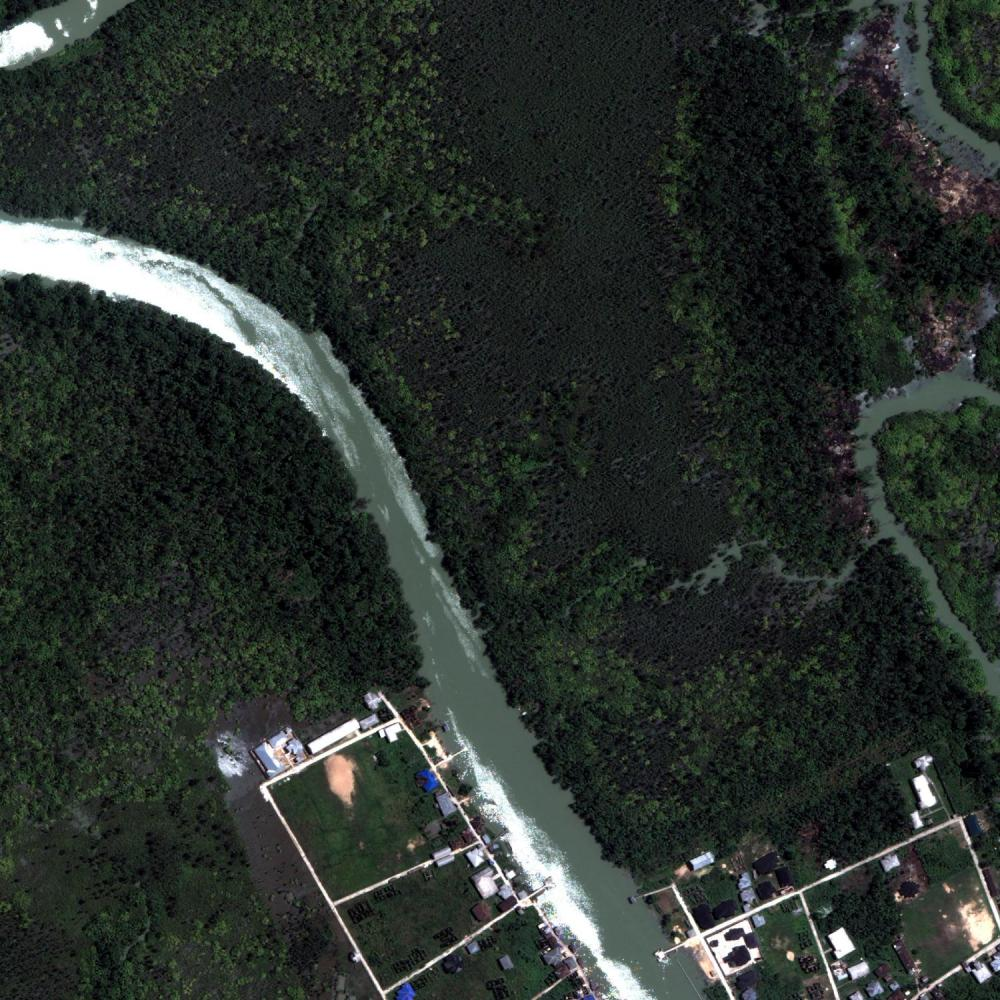

In [5]:
Image("classifiedimages/6070_2_3_a.jpg",embed=True)

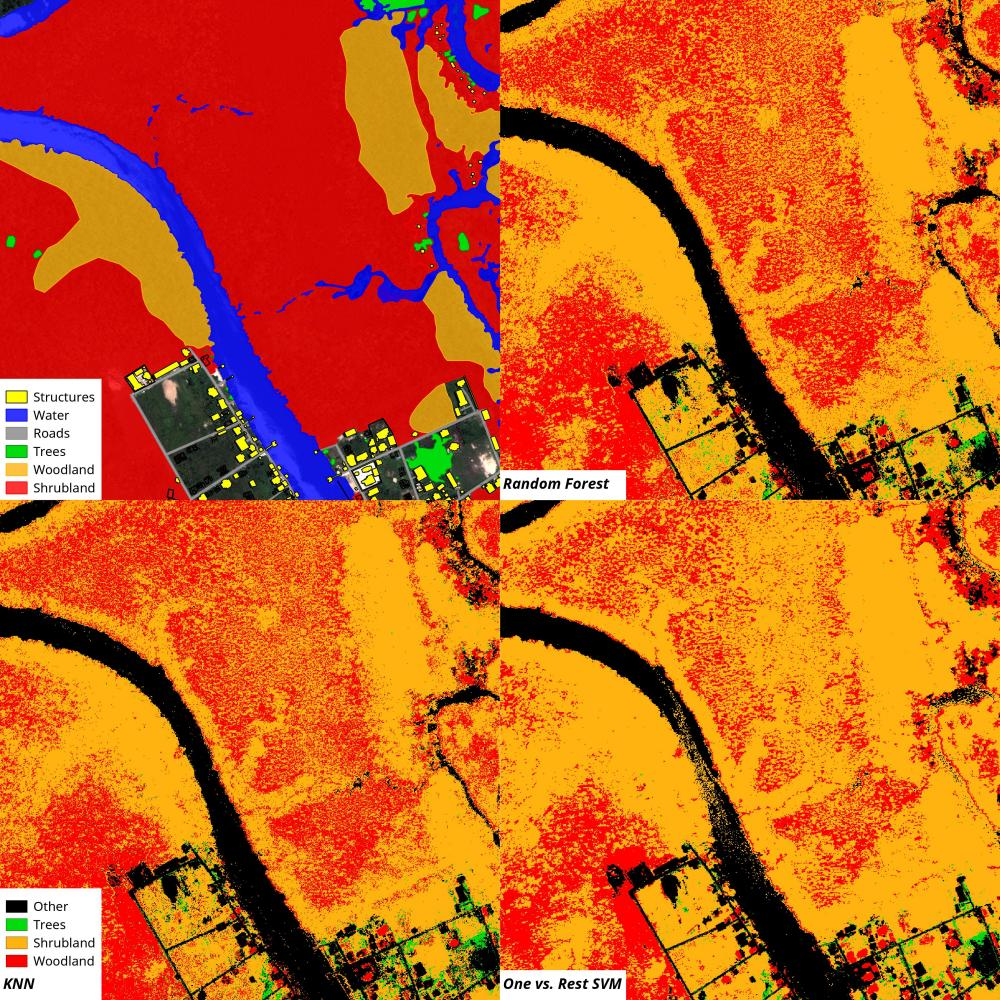

In [6]:
Image("classifiedimages/6070_2_3_b.jpg",embed=True)

The first satellite image shows a large river, urban development in the south-east, shrubland and woodland in the rest of the image.  All three models classified most of the river, roads and buildings as other.  The one-vs-rest svm model classified some areas of the river as woodland instead of other.  All models classified, the grassy and bare areas in the urban region as woodland.  This is the only satellite image that contains woodland resulting in a relatively small amount of data.  More than 75% of the woodland data was used to train the models which resulted in most of woodland areas to be classified correctly by the three models.  However a lot of shrubland regions in the image gets misclassified as woodland. Interestingly, this is the only satelite image where shrubland gets misclassified by the models as woodland.

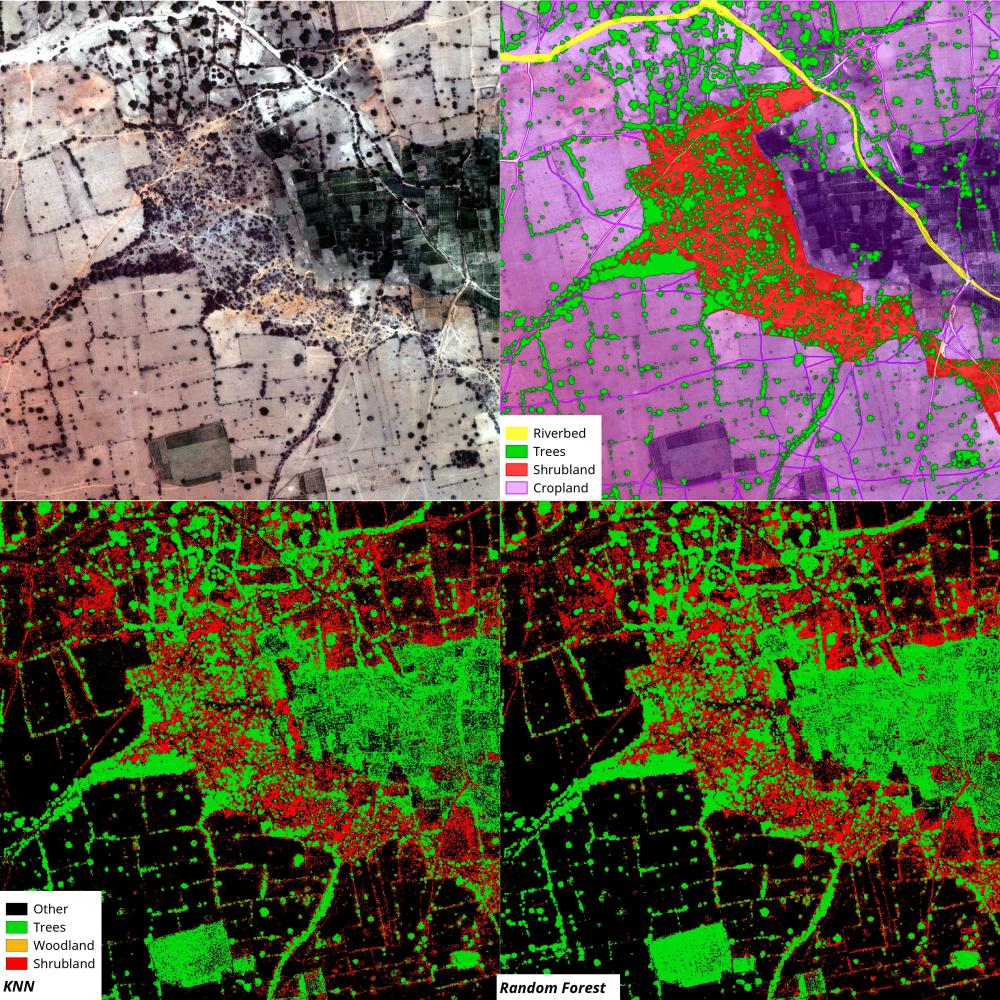

In [7]:
Image("classifiedimages/6150_2_3.jpg",embed=True)

The satellite image above mostly consists of cropland with a region of shrubland with woodland in the center of the image.  Most of the crobland was classefied correctly by the knn and random forest models as other.  However the cropland in east and a patch in the south misclassified as trees. Inspecting the satellite images it looks like these croplands have crops groing on them and are not bare like the other cropsland.  Most single trees that grow in the cropland got classified as correctly as trees by both models.  The shurbland region in the center of the image resulted in a mixed classification of shrubland and trees by both models.

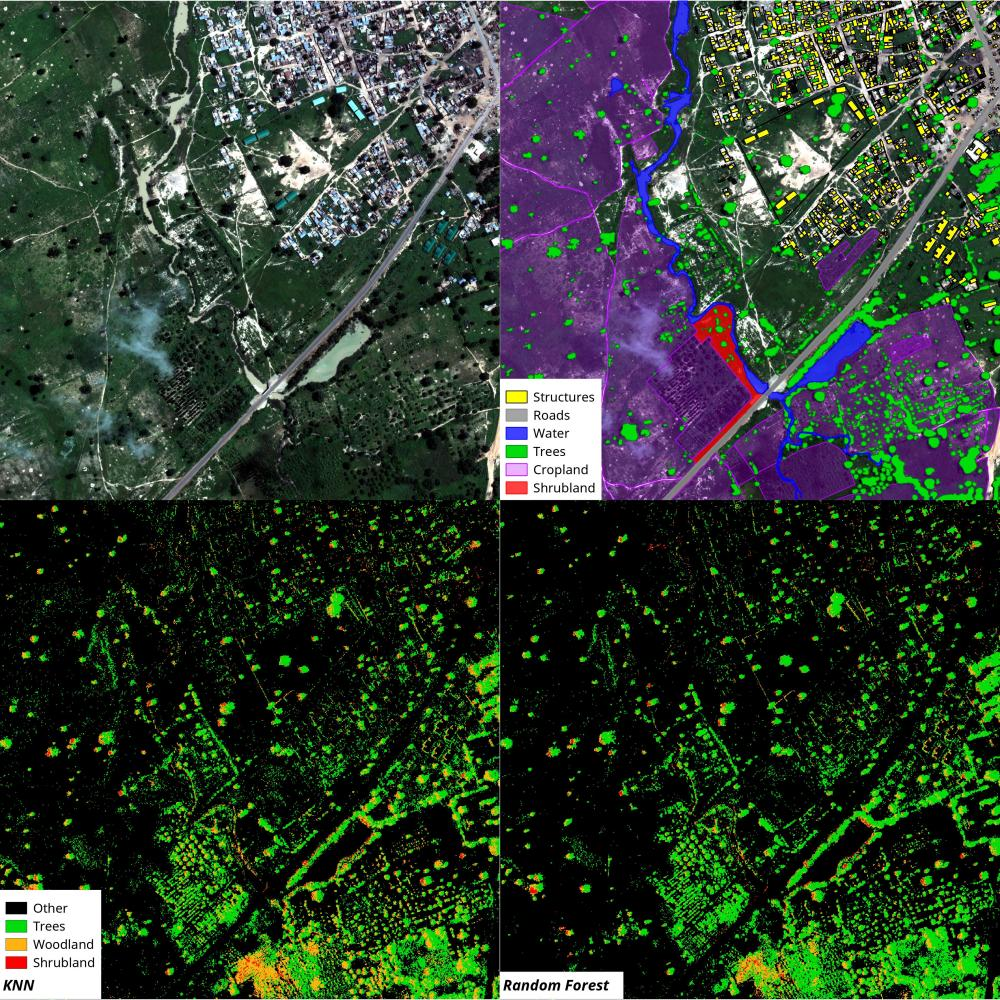

In [8]:
Image("classifiedimages/6100_2_2.jpg",embed=True)

The image above has a large urban region in the north-east of the image and the rest of the image is mostley defined as cropland.  The knn and random forest models classify most of the image as other.  The models classify the crobland that contain orchards as trees or woodland.  In the south we see a faily large patch of orchard defined as woodland, on the satellite image we see that there is shade from a cloud at this location.

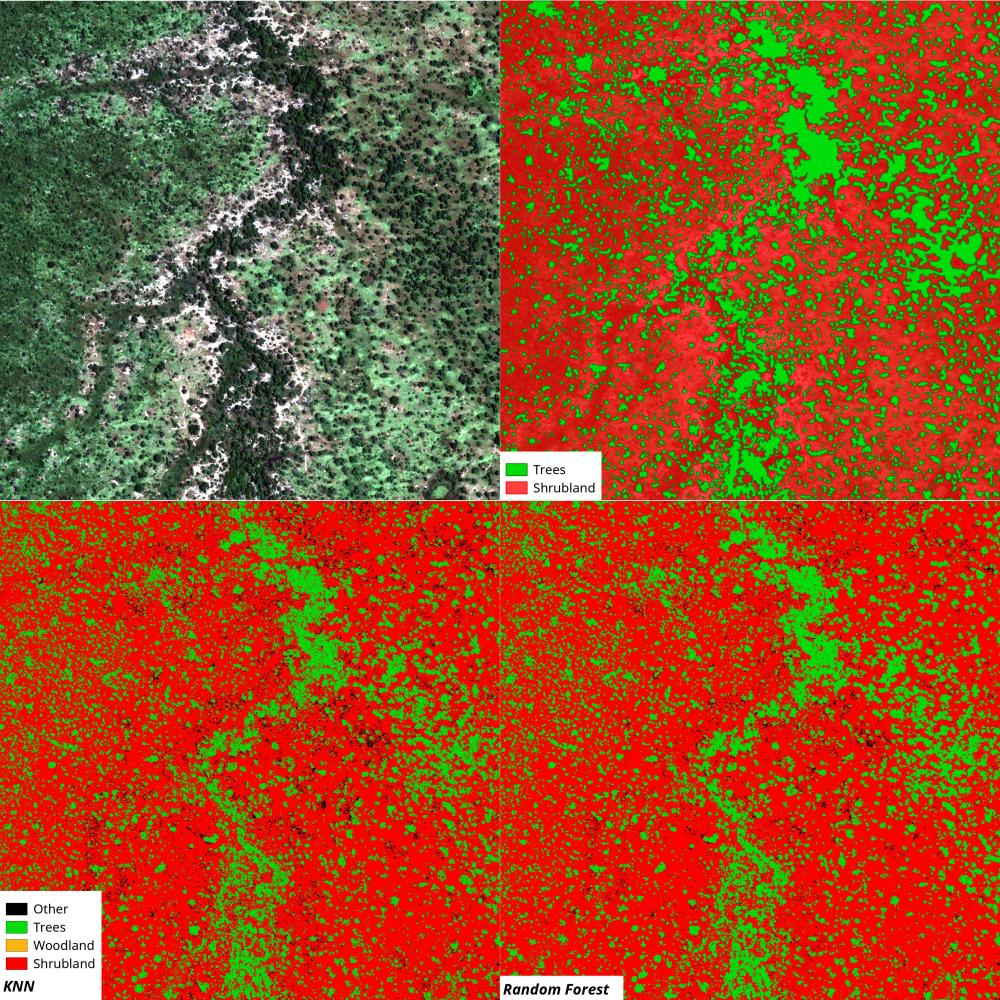

In [9]:
Image("classifiedimages/6170_0_4.jpg",embed=True)

The image above only contains shrubland and trees. This is reflected by the knn and random forest models that show a very close match to the original classified image.


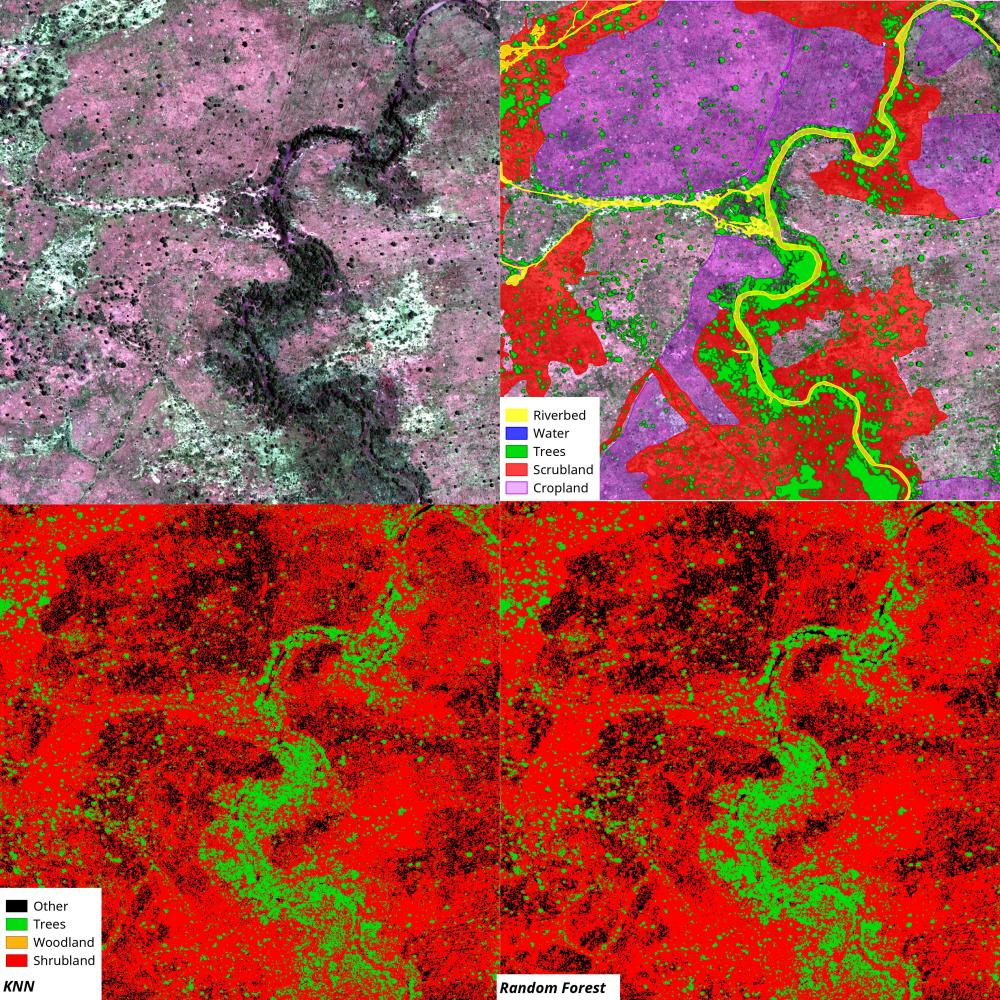

In [10]:
Image("classifiedimages/6090_2_0.jpg",embed=True)

The image above is a mix of shrubland and crobland with trees clustered around the stream bed.  Although some areas in the image were classified as other, much of the crobland was classified as shrubland by both the knn and random forest models.



In [11]:
#From the images we see that the models classify trees fairly well. Shrubland can vary from bareland with and there a bush to regions with wooded areas.